In [4]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf

print("TF version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices("GPU"))

TF version: 2.18.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [5]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [6]:
import os, pandas as pd

print(os.listdir("/kaggle/input"))

DATA_FOLDER = "/kaggle/input/cleaned-mustard-reservoir-dataset"  

df = pd.read_csv(f"{DATA_FOLDER}/cleaned_mustard_reservoir_dataset.csv")
print(df.shape)
df.head()

['cleaned-mustard-reservoir-dataset']
(95179, 24)


,crop_name,apy_item_interval_start,state_temperature_max_val,state_temperature_min_val,state_rainfall_val,yield,FRL,Live Cap FRL,Level,Current Live Storage,...,state_name_Karnataka,state_name_Madhya Pradesh,state_name_Maharashtra,state_name_Odisha,state_name_Rajasthan,state_name_Tamil Nadu,state_name_Telangana,state_name_Uttar Pradesh,state_name_Uttarakhand,state_name_West Bengal
0,rapeseed &mustard,0.0,0.522647,0.508838,0.0,0.04263,0.105176,0.978309,0.357580,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,rapeseed &mustard,0.0,0.513426,0.491502,0.0,0.04263,0.105176,0.978309,0.357382,0.990610,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,rapeseed &mustard,0.0,0.510171,0.458192,0.0,0.04263,0.105176,0.978309,0.357232,0.983725,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,rapeseed &mustard,0.0,0.511798,0.432699,0.0,0.04263,0.105176,0.978309,0.357133,0.979186,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,rapeseed &mustard,0.0,0.506103,0.467029,0.0,0.04263,0.105176,0.978309,0.357034,0.974648,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
cleaned_mustard_reservoir_dataset = df.copy()

In [8]:
df_tmp = cleaned_mustard_reservoir_dataset.copy()
df_tmp = df_tmp.sort_values("apy_item_interval_start").reset_index(drop=True)

target_col = "yield"
X_cols_all = [c for c in df_tmp.columns if c not in [target_col, "crop_name"]]

split_idx = int(len(df_tmp) * 0.8)
train_df = df_tmp.iloc[:split_idx]
test_df  = df_tmp.iloc[split_idx:]

print("Chronological split:")
print("Train size:", len(train_df), "| Test size:", len(test_df))
print("Number of features:", len(X_cols_all))


Chronological split:
Train size: 76143 | Test size: 19036
Number of features: 22


In [9]:
X_train = train_df[X_cols_all].values
y_train = train_df[target_col].values.reshape(-1, 1)

X_test  = test_df[X_cols_all].values
y_test  = test_df[target_col].values.reshape(-1, 1)

x_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))

X_train_s = x_scaler.fit_transform(X_train)
X_test_s  = x_scaler.transform(X_test)

y_train_s = y_scaler.fit_transform(y_train).ravel()
y_test_s  = y_scaler.transform(y_test).ravel()

print("Scaled shapes:")
print("X_train_s:", X_train_s.shape, "| X_test_s:", X_test_s.shape)
print("y_train_s:", y_train_s.shape, "| y_test_s:", y_test_s.shape)


Scaled shapes:
X_train_s: (76143, 22) | X_test_s: (19036, 22)
y_train_s: (76143,) | y_test_s: (19036,)


In [10]:
LOOKBACK = 24 

feature_cols_plus = X_cols_all + (['yield'] if 'yield' not in X_cols_all else [])

full_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)

X_full = x_scaler.transform(full_df[X_cols_all].values)
y_full = y_scaler.transform(full_df[[target_col]].values).ravel()

X_full_plus = np.concatenate([X_full, y_full.reshape(-1, 1)], axis=1)

def build_sequences_global(X_plus, y, lookback):
    X_seq, y_seq = [], []
    for t in range(lookback, len(X_plus)):
        X_seq.append(X_plus[t-lookback:t, :])  
        y_seq.append(y[t])                    
    return np.asarray(X_seq, np.float32), np.asarray(y_seq, np.float32)

X_seq_all, y_seq_all = build_sequences_global(X_full_plus, y_full, LOOKBACK)
print("All sequences:", X_seq_all.shape, y_seq_all.shape)


All sequences: (95155, 24, 23) (95155,)


In [11]:
n_effective = len(full_df) - LOOKBACK
n_train_eff = len(train_df) - LOOKBACK 

X_train_seq = X_seq_all[:n_train_eff]
y_train_seq = y_seq_all[:n_train_eff]

X_test_seq  = X_seq_all[n_train_eff:]
y_test_seq  = y_seq_all[n_train_eff:]

print("Train seq:", X_train_seq.shape, "| Test seq:", X_test_seq.shape)


Train seq: (76119, 24, 23) | Test seq: (19036, 24, 23)


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("BiLSTM training started...")

model_bilstm = Sequential([
    Bidirectional(LSTM(64, return_sequences=True),
                  input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.3),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1)
])

model_bilstm.compile(optimizer="adam", loss="mse")

es = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor="val_loss", factor=0.5,
                        patience=3, min_lr=1e-5, verbose=1)

history_bi = model_bilstm.fit(
    X_train_seq, y_train_seq,
    validation_split=0.1,
    epochs=60,
    batch_size=64,
    verbose=1,
    callbacks=[es, rlr]
)

print("\nBiLSTM training completed!")


BiLSTM training started...
Epoch 1/60
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 0.0109 - val_loss: 0.0036 - learning_rate: 0.0010
Epoch 2/60
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0039 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 3/60
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0035 - val_loss: 0.0034 - learning_rate: 0.0010
Epoch 4/60
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0036 - val_loss: 0.0034 - learning_rate: 0.0010
Epoch 5/60
1069/1071 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0034
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0034 - val_loss: 0.0043 - learning_rate: 0.0010
Epoch 6/60
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0033 - val_loss: 0.0035 - learning_rate: 5.0000e-04
Epoch 7/60
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0033 - val_loss: 0.0043 - learning_rate: 5.0000e-04
Epoch 8/60
1066/1071 ━━━━━━━━━━━━━━━━━━━━ 0s 8

In [14]:
y_pred_bi_s = model_bilstm.predict(X_test_seq, verbose=0).ravel()

y_pred_bilstm = y_scaler.inverse_transform(y_pred_bi_s.reshape(-1, 1)).ravel()
y_true_bi    = y_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).ravel()

mse_bilstm  = mean_squared_error(y_true_bi, y_pred_bilstm)
mae_bilstm  = mean_absolute_error(y_true_bi, y_pred_bilstm)
rmse_bilstm = np.sqrt(mse_bilstm)
r2_bilstm   = r2_score(y_true_bi, y_pred_bilstm)

print("\nBiLSTM Results – MUSTARD")
print(f"MSE : {mse_bilstm:.6f}")
print(f"MAE : {mae_bilstm:.6f}")
print(f"RMSE: {rmse_bilstm:.6f}")
print(f"R²  : {r2_bilstm:.6f}")



BiLSTM Results – MUSTARD
MSE : 0.003787
MAE : 0.040695
RMSE: 0.061540
R²  : 0.925420


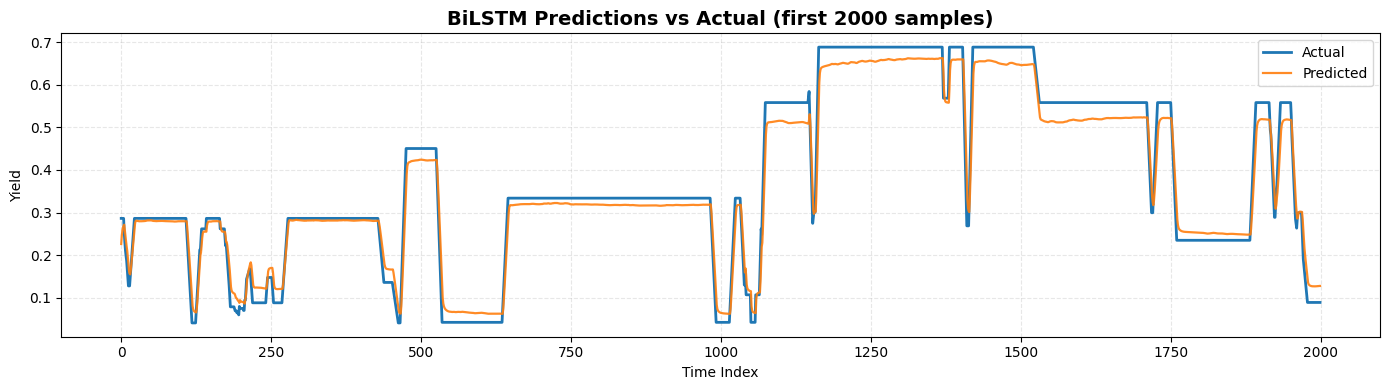

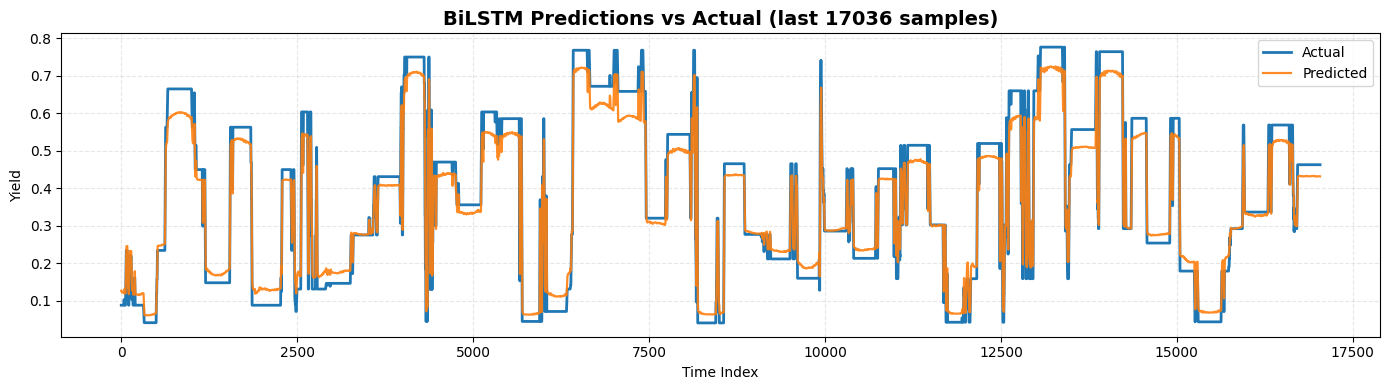

In [15]:
import matplotlib.pyplot as plt

yt_bi = np.array(y_true_bi).ravel()
yp_bi = np.array(y_pred_bilstm).ravel()

SMOOTH = 10
yt_bi_s = pd.Series(yt_bi).rolling(SMOOTH, min_periods=1).mean().values
yp_bi_s = pd.Series(yp_bi).rolling(SMOOTH, min_periods=1).mean().values

def plot_seq_bilstm(actual, pred, title):
    plt.figure(figsize=(14,4))
    plt.plot(actual, label="Actual", linewidth=2)
    plt.plot(pred,   label="Predicted", linewidth=1.6, alpha=0.9)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel("Time Index")
    plt.ylabel("Yield")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

N = min(2000, len(yt_bi_s)//2)

plot_seq_bilstm(yt_bi_s[:N], yp_bi_s[:N],
                f"BiLSTM Predictions vs Actual (first {N} samples)")

plot_seq_bilstm(yt_bi_s[N:], yp_bi_s[N:],
                f"BiLSTM Predictions vs Actual (last {len(yt_bi_s)-N} samples)")


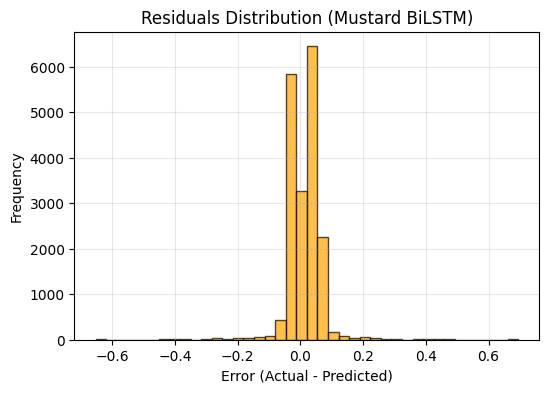

In [18]:
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=40, color='orange', edgecolor='black', alpha=0.7)
plt.title("Residuals Distribution (Mustard BiLSTM)")
plt.xlabel("Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()


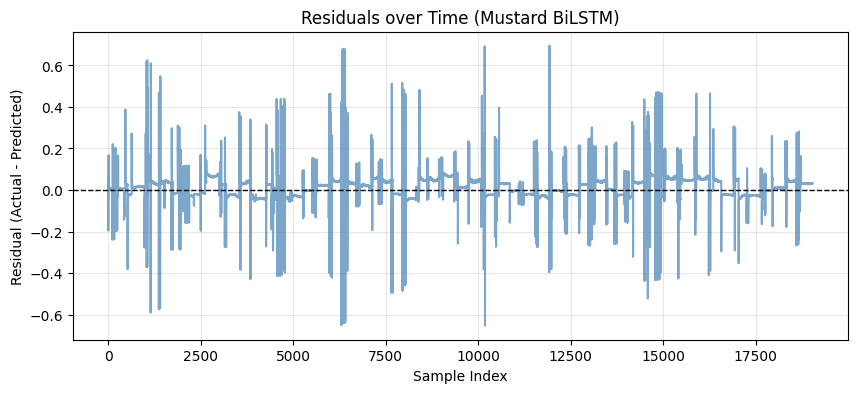

In [16]:
import matplotlib.pyplot as plt
import numpy as np

residuals = y_true_bi - y_pred_bilstm

plt.figure(figsize=(10,4))
plt.plot(residuals, color='steelblue', alpha=0.7)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title("Residuals over Time (Mustard BiLSTM)")
plt.xlabel("Sample Index")
plt.ylabel("Residual (Actual - Predicted)")
plt.grid(alpha=0.3)
plt.show()


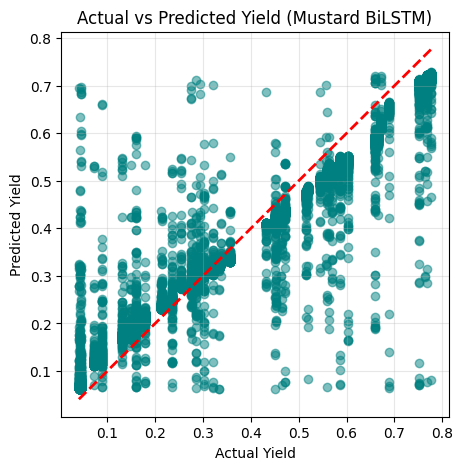

In [17]:
plt.figure(figsize=(5,5))
plt.scatter(y_true_bi, y_pred_bilstm, alpha=0.5, color='teal')
plt.plot([y_true_bi.min(), y_true_bi.max()],
         [y_true_bi.min(), y_true_bi.max()],
         'r--', lw=2)
plt.title("Actual vs Predicted Yield (Mustard BiLSTM)")
plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.grid(alpha=0.3)
plt.show()


In [34]:
#================ FORECASTING ================#


# Check unique years available in your dataset
print("Years present in the dataset:")
print(sorted(df_final["year"].unique()))

print("\nTotal number of years:", len(df_final["year"].unique()))


Years present in the dataset:
[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100, 2101, 2102, 2103, 2104, 2105, 2106, 2107, 2108, 2109, 2110, 2111, 2112, 2113, 2114, 2115, 2116, 2117, 2118, 2119, 2120, 2121, 2122, 2123, 2124, 2125, 2126, 2127, 2128, 2129, 2130, 2131, 2132, 2133, 2134, 2135, 2136, 2137, 2138, 2139, 2140, 2141, 2142, 2143, 2144, 2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154, 2155, 2156, 2157, 2158, 2159, 2160, 2161, 2162, 2163, 2164, 2165, 2166, 2167, 2168, 2169, 2170, 217

In [50]:
import numpy as np
import pandas as pd

df_final = cleaned_mustard_reservoir_dataset.copy().reset_index(drop=True)

if "__row_order__" not in df_final.columns:
    df_final["__row_order__"] = np.arange(len(df_final))

if "year" not in df_final.columns:
    print("No 'year' column found. Creating synthetic one...")
    df_final["year"] = df_final["__row_order__"] // 500 + 2010

df_final["year"] = pd.to_numeric(df_final["year"], errors="coerce")
df_final["year"] = df_final["year"].ffill().bfill().astype(int)

print("Year range:", df_final["year"].min(), "→", df_final["year"].max())
print("Unique years:", len(df_final["year"].unique()))

feature_cols = [c for c in df_final.columns 
                if c not in ["yield", "crop_name", "__row_order__", "year"]]
print("Features used:", len(feature_cols))

state_cols = [c for c in df_final.columns if c.startswith("state_name_")]
print("State columns detected:", state_cols)


No 'year' column found. Creating synthetic one...
Year range: 2010 → 2200
Unique years: 191
Features used: 22
State columns detected: ['state_name_Andhra Pradesh', 'state_name_Chhattisgarh', 'state_name_Gujarat', 'state_name_Jharkhand', 'state_name_Karnataka', 'state_name_Madhya Pradesh', 'state_name_Maharashtra', 'state_name_Odisha', 'state_name_Rajasthan', 'state_name_Tamil Nadu', 'state_name_Telangana', 'state_name_Uttar Pradesh', 'state_name_Uttarakhand', 'state_name_West Bengal']


In [51]:
LOOKBACK = 24  

def build_sequences_full(df, feature_cols, target_col, lookback,
                         x_scaler, y_scaler, state_cols):

    df = df.sort_values("__row_order__", ascending=True).reset_index(drop=True)

    X_full = x_scaler.transform(df[feature_cols].values)
    y_full = y_scaler.transform(df[[target_col]].values).ravel()

    years = df["year"].values

    if state_cols:
        states = df[state_cols].idxmax(axis=1).str.replace("state_name_", "")
    else:
        states = np.array(["ALL"] * len(df))

    X_plus = np.concatenate([X_full, y_full.reshape(-1, 1)], axis=1)

    X_seq, y_seq, year_list, state_list = [], [], [], []

    for t in range(lookback, len(df)):
        X_seq.append(X_plus[t - lookback:t, :])
        y_seq.append(y_full[t])
        year_list.append(years[t])
        state_list.append(states[t])

    X_seq = np.asarray(X_seq, dtype=np.float32)
    y_seq = np.asarray(y_seq, dtype=np.float32)
    year_arr = np.asarray(year_list)
    state_arr = np.asarray(state_list, dtype=object)

    print("All sequences:", X_seq.shape, y_seq.shape)
    return X_seq, y_seq, year_arr, state_arr


X_seq_all, y_seq_all, years_all, states_all = build_sequences_full(
    df_final, feature_cols, "yield", LOOKBACK,
    x_scaler, y_scaler, state_cols
)


All sequences: (95155, 24, 23) (95155,)


In [54]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("Predicting for all sequences...")
y_pred_all_scaled = model_bilstm.predict(X_seq_all, verbose=0).ravel()

# Inverse scale to original yield
y_true_all = y_scaler.inverse_transform(y_seq_all.reshape(-1, 1)).ravel()
y_pred_all = y_scaler.inverse_transform(y_pred_all_scaled.reshape(-1, 1)).ravel()

print("Done. Total sequences:", len(y_true_all))


Predicting for all sequences...
Done. Total sequences: 95155


In [56]:
K = 100          
TARGET_YEAR = 2025  

results = []

for st_name in np.unique(states_all):
    idx_all = np.where(states_all == st_name)[0]
    if len(idx_all) == 0:
        continue
    
    if len(idx_all) > K:
        idx_sel = idx_all[-K:]
    else:
        idx_sel = idx_all

    yt = y_true_all[idx_sel]
    yp = y_pred_all[idx_sel]

    mse  = mean_squared_error(yt, yp)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(yt, yp)

    results.append({
        "state_name": st_name,
        "year": TARGET_YEAR,          
        "y_true_mean": round(yt.mean(), 6),
        "y_pred_mean": round(yp.mean(), 6),
        "mse": round(mse, 6),
        "rmse": round(rmse, 6),
        "mae": round(mae, 6),
    })

results_df = pd.DataFrame(results).sort_values("state_name").reset_index(drop=True)

print("\n Model Used: BiLSTM")
print(f"State-wise Forecast Results for YEAR {TARGET_YEAR}")
display(results_df)



 Model Used: BiLSTM
State-wise Forecast Results for YEAR 2025


,state_name,year,y_true_mean,y_pred_mean,mse,rmse,mae
0,Andhra Pradesh,2025,0.254404,0.278916,0.000602,0.024541,0.024512
1,Chhattisgarh,2025,0.179723,0.214673,0.001253,0.035400,0.034950
2,Gujarat,2025,0.764461,0.702082,0.003913,0.062555,0.062379
3,Jharkhand,2025,0.292755,0.297118,0.000025,0.005042,0.004363
4,Karnataka,2025,0.064340,0.079226,0.000222,0.014901,0.014885
5,Madhya Pradesh,2025,0.586926,0.536462,0.002557,0.050569,0.050464
6,Maharashtra,2025,0.072090,0.117338,0.002058,0.045371,0.045248
7,Odisha,2025,0.025444,0.016607,0.000079,0.008883,0.008837
8,Rajasthan,2025,0.556924,0.508368,0.002358,0.048560,0.048556
9,Tamil Nadu,2025,0.044417,0.072525,0.000798,0.028251,0.028108
